In [19]:
%matplotlib inline

In [20]:
import argparse
import colorsys
import imghdr
import os
import random

import matplotlib.pyplot as plt

import numpy as np
from keras import backend as K
from keras.models import load_model
from PIL import Image, ImageDraw, ImageFont

from yad2k.yad2k.models.keras_yolo import yolo_eval, yolo_head

In [21]:
model_path = os.path.expanduser('yad2k/model_data/yolo.h5')
anchors_path = os.path.expanduser('yad2k/model_data/yolo_anchors.txt')
classes_path = os.path.expanduser('yad2k/model_data/coco_classes.txt')
test_path = os.path.expanduser('yad2k/images')
output_path = os.path.expanduser('yad2k/images/out')

In [22]:
if not os.path.exists(output_path):
    print('Creating output path {}'.format(output_path))
    os.mkdir(output_path)

with open(classes_path) as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]

with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)

yolo_model = load_model(model_path)

/root/anaconda3/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [23]:
# Verify model, anchors, and classes are compatible
num_classes = len(class_names)
num_anchors = len(anchors)
# TODO: Assumes dim ordering is channel last
model_output_channels = yolo_model.layers[-1].output_shape[-1]
assert model_output_channels == num_anchors * (num_classes + 5), \
    'Mismatch between model and given anchor and class sizes. ' \
    'Specify matching anchors and classes with --anchors_path and ' \
    '--classes_path flags.'
print('{} model, anchors, and classes loaded.'.format(model_path))

yad2k/model_data/yolo.h5 model, anchors, and classes loaded.


In [24]:
# Check if model is fully convolutional, assuming channel last order.
model_image_size = yolo_model.layers[0].input_shape[1:3]
is_fixed_size = model_image_size != (None, None)
is_fixed_size

True

In [25]:
model_image_size

(608, 608)

# Explore the model

In [26]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [27]:
print(len(class_names))
print(class_names)

80
['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## Colors

In [28]:
# Generate colors for drawing bounding boxes.
hsv_tuples = [(x / len(class_names), 1., 1.)
              for x in range(len(class_names))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(
    map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
        colors))
random.seed(10101)  # Fixed seed for consistent colors across runs.
random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
random.seed(None)  # Reset seed to default.

In [29]:
len(colors)

80

/root/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


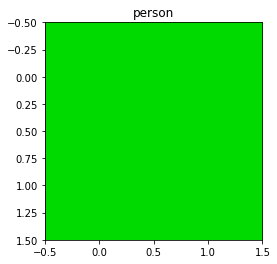

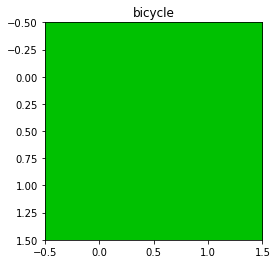

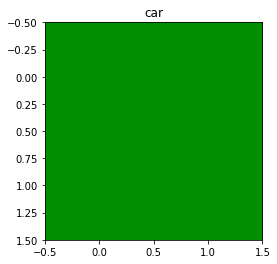

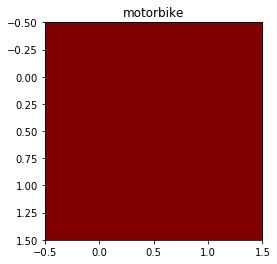

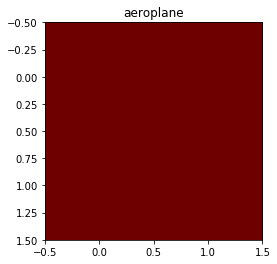

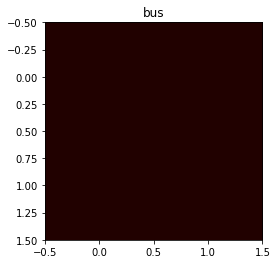

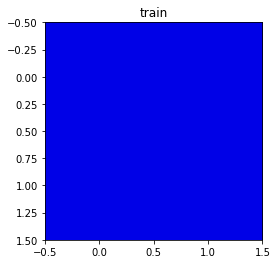

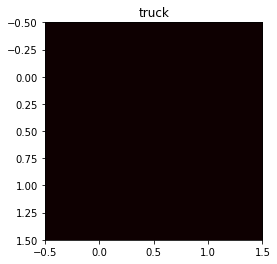

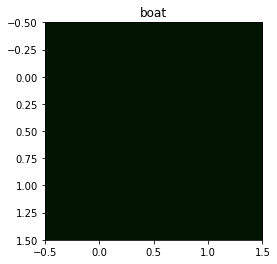

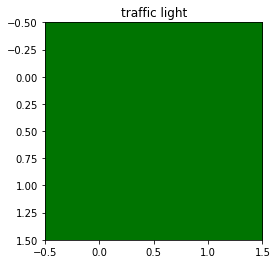

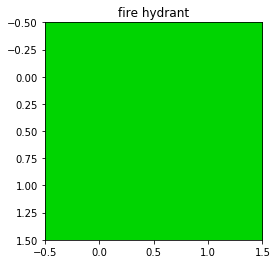

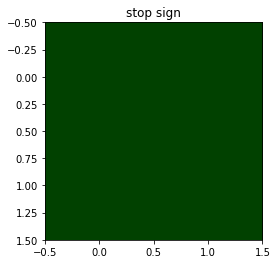

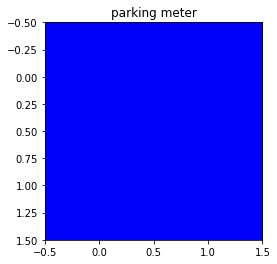

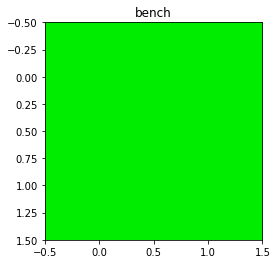

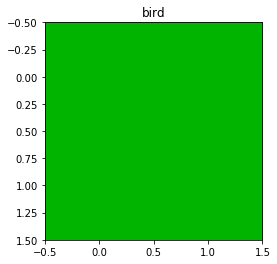

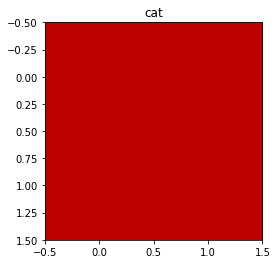

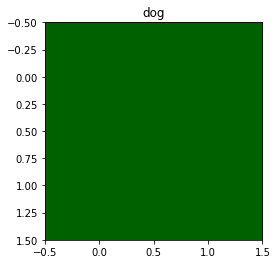

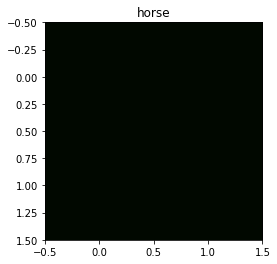

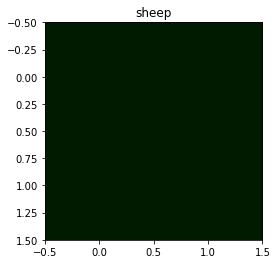

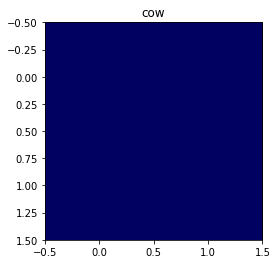

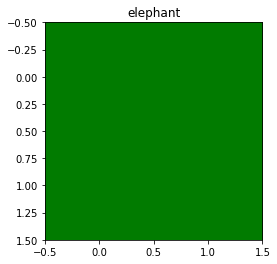

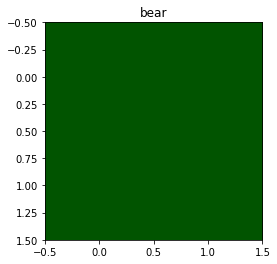

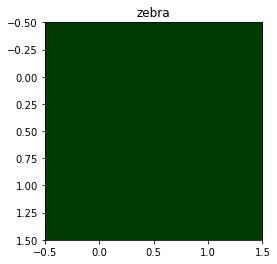

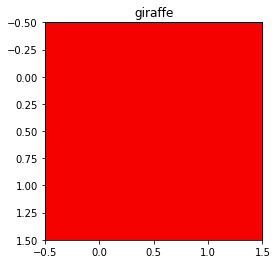

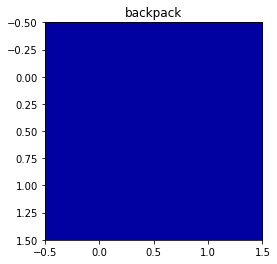

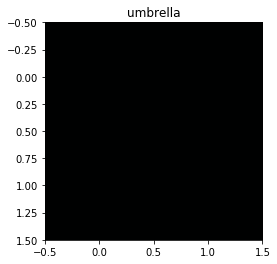

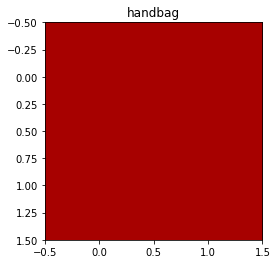

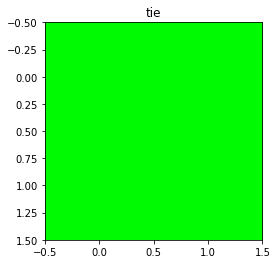

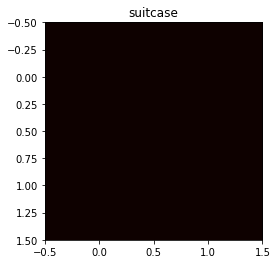

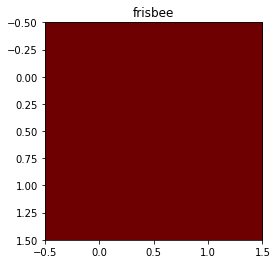

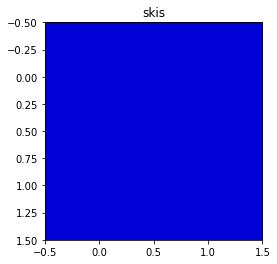

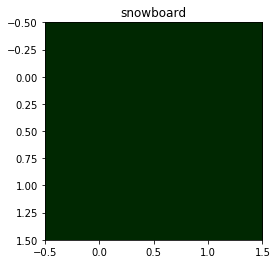

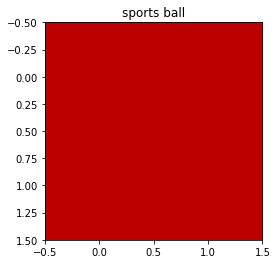

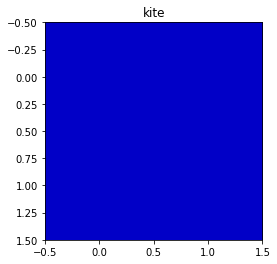

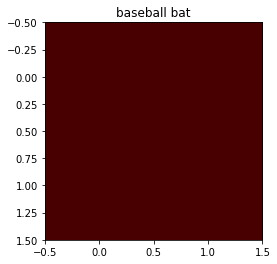

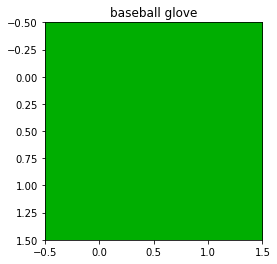

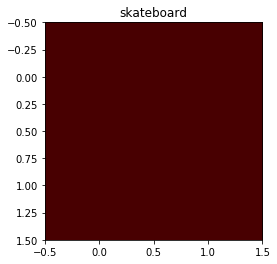

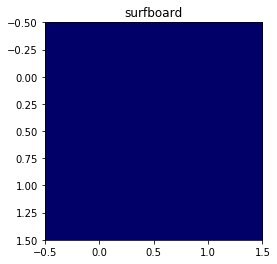

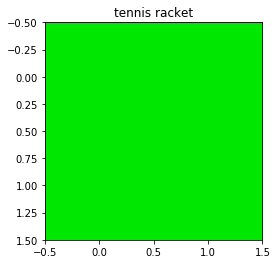

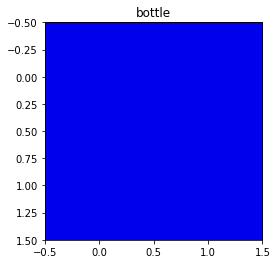

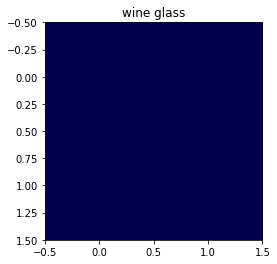

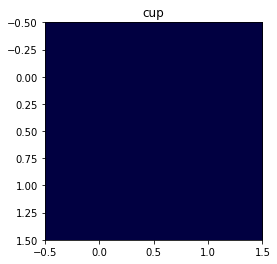

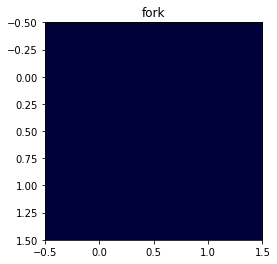

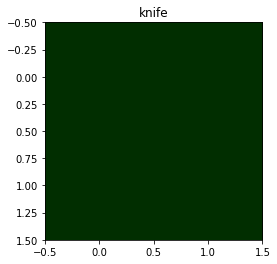

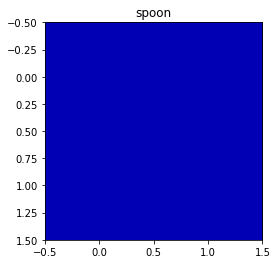

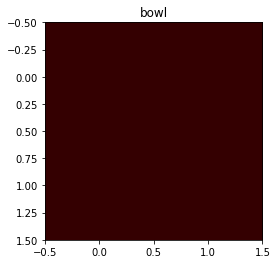

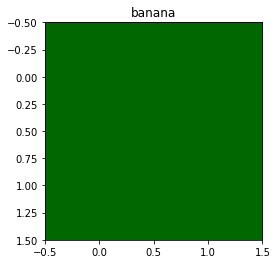

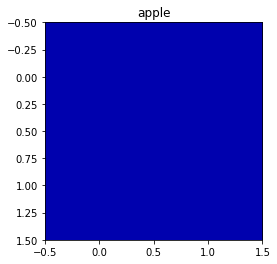

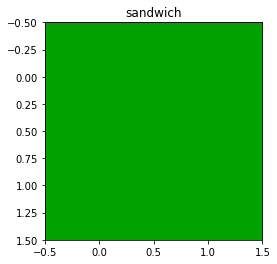

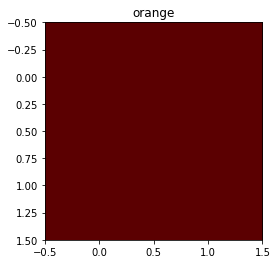

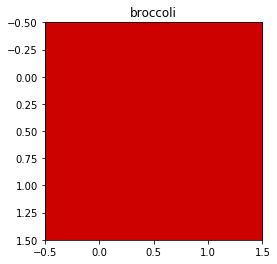

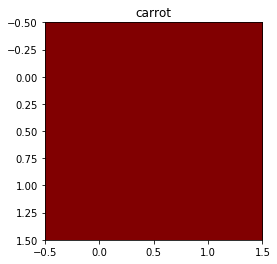

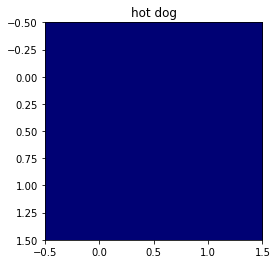

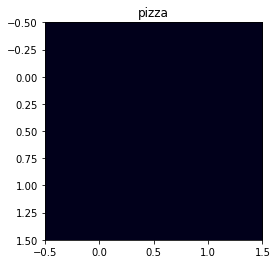

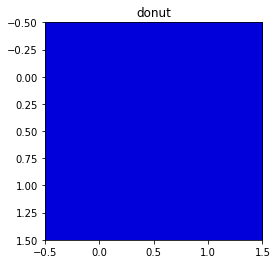

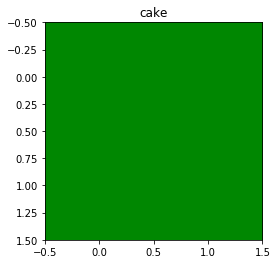

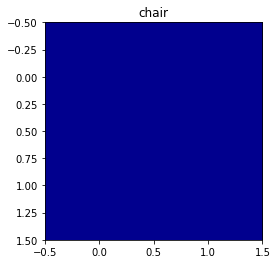

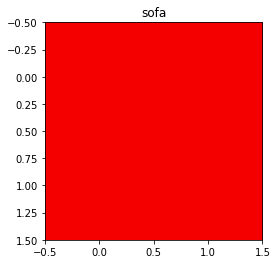

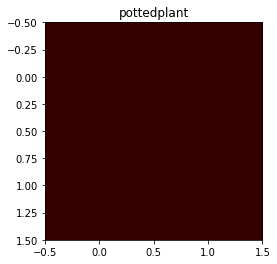

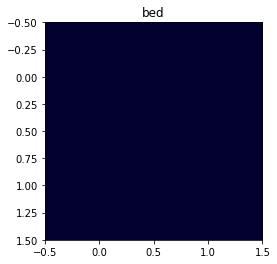

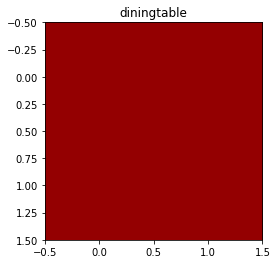

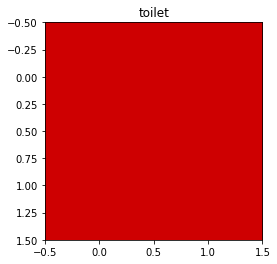

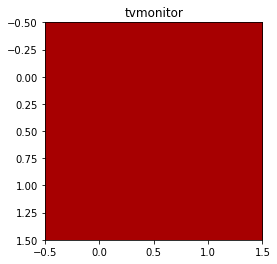

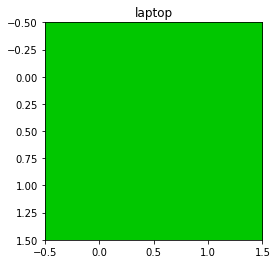

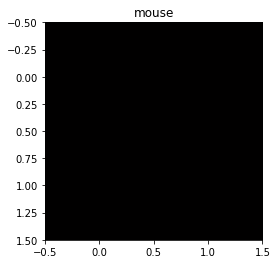

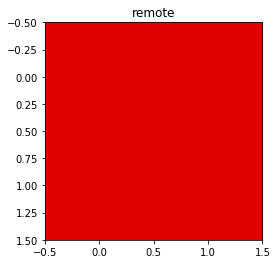

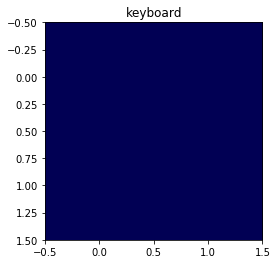

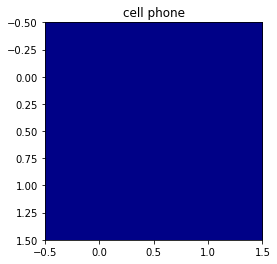

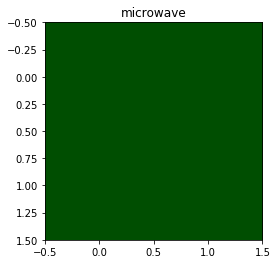

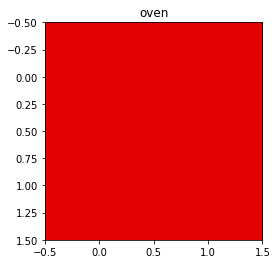

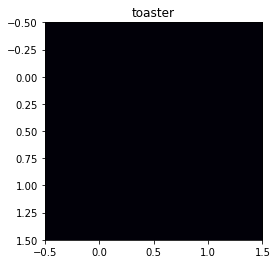

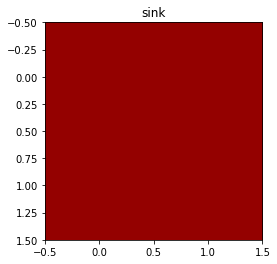

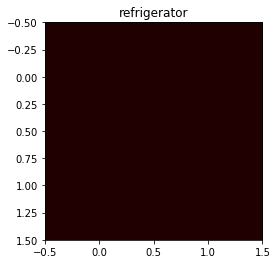

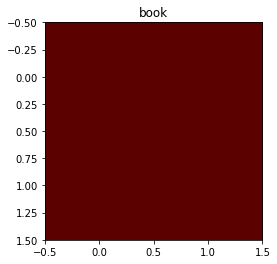

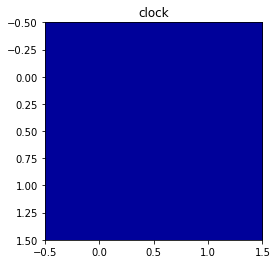

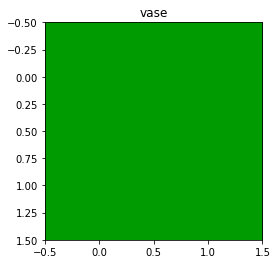

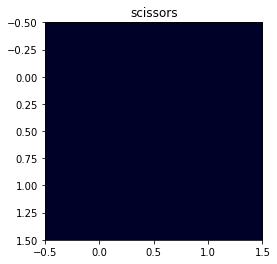

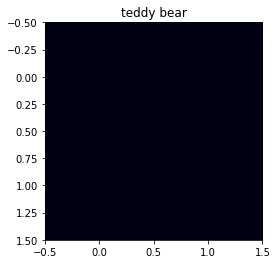

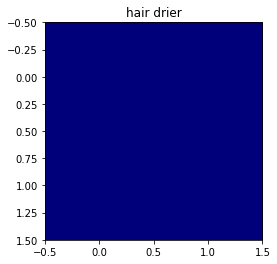

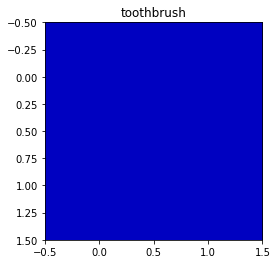

In [30]:
for i in range(len(class_names)):
    color = colors[i]
    im = np.zeros(shape=(2, 2, 3)) + np.asarray(color).reshape((1,1,3))
    plt.figure()
    plt.title(class_names[i])
    plt.imshow(im)

## Some magic

In [31]:
score_threshold = .3
iou_threshold = .5

In [32]:
# Generate output tensor targets for filtered bounding boxes.
# TODO: Wrap these backend operations with Keras layers.
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(
    yolo_outputs,
    input_image_shape,
    score_threshold=score_threshold,
    iou_threshold=iou_threshold)

sess = K.get_session()  # TODO: Remove dependence on Tensorflow session.

conv_dims Tensor("strided_slice_19:0", shape=(2,), dtype=int32)
conv_height_index Tensor("arange_2:0", shape=(?,), dtype=int32)
conv_width_index Tensor("arange_3:0", shape=(?,), dtype=int32)
conv_height_index Tensor("Tile_2:0", shape=(?,), dtype=int32)
conv_width_index Tensor("Tile_3:0", shape=(?, ?), dtype=int32)
conv_width_index Tensor("Reshape_9:0", shape=(?,), dtype=int32)
conv_index Tensor("transpose_3:0", shape=(?, 2), dtype=int32)
conv_index Tensor("Reshape_10:0", shape=(1, ?, ?, 1, 2), dtype=int32)
conv_index Tensor("Cast_2:0", shape=(1, ?, ?, 1, 2), dtype=float32)
feats Tensor("Reshape_11:0", shape=(?, ?, ?, 5, 85), dtype=float32)
conv_dims Tensor("Cast_3:0", shape=(1, 1, 1, 1, 2), dtype=float32)


In [33]:
boxes.shape

TensorShape([Dimension(None), Dimension(4)])

In [34]:
scores.shape

TensorShape([Dimension(None)])

In [35]:
classes.shape

TensorShape([Dimension(None)])

## Prediction

In [36]:
for image_file in os.listdir(test_path):
    image_filepath = os.path.join(test_path, image_file)
    try:
        image_type = imghdr.what(image_filepath)
        if not image_type:
            continue
    except IsADirectoryError:
        continue

    image = Image.open(image_filepath)
    if is_fixed_size:  # TODO: When resizing we can use minibatch input.
        resized_image = image.resize(
            tuple(reversed(model_image_size)), Image.BICUBIC)
        image_data = np.array(resized_image, dtype='float32')
    else:
        # Due to skip connection + max pooling in YOLO_v2, inputs must have
        # width and height as multiples of 32.
        new_image_size = (image.width - (image.width % 32),
                          image.height - (image.height % 32))
        resized_image = image.resize(new_image_size, Image.BICUBIC)
        image_data = np.array(resized_image, dtype='float32')
        print(image_data.shape)

    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

    out_boxes, out_scores, out_classes = sess.run(
        [boxes, scores, classes],
        feed_dict={
            yolo_model.input: image_data,
            input_image_shape: [image.size[1], image.size[0]],
            K.learning_phase(): 0
        })
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))

    font = ImageFont.truetype(
        font='yad2k/font/FiraMono-Medium.otf',
        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    image.save(os.path.join(output_path, image_file), quality=90)

Found 3 boxes for person.jpg
dog 0.79 (70, 258) (209, 356)
person 0.81 (190, 98) (271, 379)
horse 0.89 (399, 128) (605, 352)
Found 3 boxes for dog.jpg
dog 0.78 (137, 214) (323, 540)
truck 0.80 (462, 82) (694, 168)
bicycle 0.84 (81, 112) (554, 469)
Found 0 boxes for scream.jpg
Found 1 boxes for eagle.jpg
bird 0.95 (128, 48) (643, 468)
Found 2 boxes for giraffe.jpg
zebra 0.83 (241, 208) (422, 442)
giraffe 0.89 (166, 0) (439, 448)
Found 4 boxes for horses.jpg
horse 0.65 (0, 188) (169, 378)
horse 0.75 (253, 196) (436, 371)
horse 0.89 (435, 210) (603, 350)
horse 0.89 (6, 193) (305, 411)


In [37]:
sess.close()